In [ ]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

2024-06-11 20:49:37.522053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 20:49:37.522163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 20:49:37.653418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
from keras.layers import Input, Conv2D, LeakyReLU, UpSampling2D, Concatenate, Dropout, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence


In [25]:
# pip freeze > requirements.txt


In [48]:
import tensorflow as tf
import os
from kaggle_datasets import KaggleDatasets

# Задайте путь к директории с изображениями Monet
GCS_PATH_MONET = '/kaggle/input/monet-paintings-jpg-berkeley'
# Получите список всех JPG файлов в директории Monet
MONET_FILENAMES = [os.path.join(GCS_PATH_MONET, f) for f in os.listdir(GCS_PATH_MONET) if f.endswith('.jpg')]
print('Monet JPG Files:', len(MONET_FILENAMES))

# Задайте путь к директории с фотографиями
GCS_PATH_PHOTO = '/kaggle/input/landscape-image-colorization/landscape Images/color'
# Получите список всех JPG файлов в директории с фотографиями
PHOTO_FILENAMES = [os.path.join(GCS_PATH_PHOTO, f) for f in os.listdir(GCS_PATH_PHOTO) if f.endswith('.jpg')]
print('Photo JPG Files:', len(PHOTO_FILENAMES))

IMAGE_SIZE = [256, 256]
BATCH_SIZE = 10  # Размер батча

def decode_image(image_path):
    image = tf.io.read_file(image_path)  # Считывание изображения из файла
    image = tf.image.decode_jpeg(image, channels=3)  # Декодирование JPG изображения
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Нормализация изображения
    image = tf.image.resize(image, IMAGE_SIZE)  # Изменение размера изображения
    return image

def load_image_dataset(image_filenames, batch_size):
    # Создайте tf.data.Dataset из списка файлов
    dataset = tf.data.Dataset.from_tensor_slices(image_filenames)
    # Примените декодирование к каждому изображению
    dataset = dataset.map(lambda x: decode_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Объедините данные в батчи
    dataset = dataset.batch(batch_size)
    return dataset

# Загрузка датасета с изображениями Monet
monet_dataset = load_image_dataset(MONET_FILENAMES, BATCH_SIZE)

# Загрузка датасета с фотографиями
photo_dataset = load_image_dataset(PHOTO_FILENAMES, BATCH_SIZE)

# Пример: просмотр количества изображений в каждом батче для Monet
print("Monet Dataset:")
for i, image_batch in enumerate(monet_dataset.take(1)):  # Отобразим только первый батч
    print(f'Batch {i + 1} shape: {image_batch.shape}')

# Пример: просмотр количества изображений в каждом батче для фото
print("Photo Dataset:")
for i, image_batch in enumerate(photo_dataset.take(1)):  # Отобразим только первый батч
    print(f'Batch {i + 1} shape: {image_batch.shape}')


Monet JPG Files: 1193
Photo JPG Files: 7129
Monet Dataset:
Batch 1 shape: (10, 256, 256, 3)
Photo Dataset:
Batch 1 shape: (10, 256, 256, 3)


In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [38]:
monet_ds = load_dataset(monet_dataset, labeled=True).batch(1)
photo_ds = load_dataset(photo_dataset, labeled=True).batch(1)

NameError: name 'load_dataset' is not defined

In [49]:
example_monet = next(iter(monet_dataset))
example_photo = next(iter(photo_dataset))


In [40]:
import matplotlib.pyplot as plt

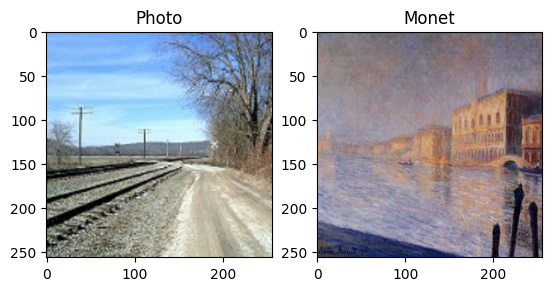

In [50]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [3]:
def conv2d(layer_input, filters, f_size=4):
    """Layers used during downsampling"""
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    d = InstanceNormalization()(d)
    return d

def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    """Layers used during upsampling"""
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
    if dropout_rate:
         u = Dropout(dropout_rate)(u)
    u = InstanceNormalization()(u)
    u = Concatenate()([u, skip_input])
    return u

def Generator():
    """U-Net Generator"""
    d0 = Input(shape=img_shape)
    # Downsampling
    d1 = conv2d(d0, gf)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)

    # Upsampling
    u1 = deconv2d(d4, d3, gf*4)
    u2 = deconv2d(u1, d2, gf*2)
    u3 = deconv2d(u2, d1, gf)

    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output_img)

    
def d_layer(layer_input, filters, f_size=4, normalization=True):
    """Discriminator layer"""
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if normalization:
        d = InstanceNormalization()(d)
    return d  

def Discriminator():
    img = Input(shape=img_shape)
    d1 = d_layer(img, df, normalization=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)

In [4]:
strategy = tf.distribute.get_strategy()

In [5]:
class InstanceNormalization(Layer):
    def __init__(self, axis=-1, epsilon=1e-5, **kwargs):
        self.axis = axis
        self.epsilon = epsilon
        super(InstanceNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[self.axis],), initializer="ones", trainable=True)
        self.beta = self.add_weight(shape=(input_shape[self.axis],), initializer="zeros", trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, [1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (inputs - mean) * inv
        return self.gamma * normalized + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

In [6]:
img_shape = (256, 256, 3)
gf = 32
df = 64
channels = 3
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet style")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

NameError: name 'example_photo' is not defined

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator()

In [8]:
class CycleGan(tf.keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=12):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
    def call(self, inputs, training=None, mask=None):
        # Предположим, что inputs — это изображение
        # Пропустим через генератор
        fake_monet = self.m_gen(inputs, training=training)
        return fake_monet
    
    def get_config(self):
        config = super(CycleGan, self).get_config()
        config.update({
            'monet_generator': self.m_gen,
            'photo_generator': self.p_gen,
            'monet_discriminator': self.m_disc,
            'photo_discriminator': self.p_disc,
            'lambda_cycle': self.lambda_cycle
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [9]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [10]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [11]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [12]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [13]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
    photo_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

In [14]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [15]:
class PrintLosses(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - Generator Loss: {logs['gen_loss']}, Discriminator Loss: {logs['disc_loss']}")


In [16]:

import matplotlib.pyplot as plt

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_loss = {
            'total_loss': []
        }

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch_loss['total_loss'].append(logs.get('loss'))

        print(f"Epoch {epoch + 1}: Total Loss: {logs.get('loss'):.4f}")

    def on_train_end(self, logs=None):
        # Plotting the total loss values
        plt.figure(figsize=(12, 8))
        epochs = range(1, len(self.epoch_loss['total_loss']) + 1)

        plt.plot(epochs, self.epoch_loss['total_loss'], label='Total Loss')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Total Loss over Epochs')
        plt.legend()
        plt.show()

# Example usage of the custom callback
loss_history = LossHistory()


In [18]:
import tensorflow as tf
import os
from kaggle_datasets import KaggleDatasets

# Задайте путь к директории с изображениями Monet
GCS_PATH_MONET = '/kaggle/input/monet-paintings-jpg-berkeley'
# Получите список всех JPG файлов в директории Monet
MONET_FILENAMES = [os.path.join(GCS_PATH_MONET, f) for f in os.listdir(GCS_PATH_MONET) if f.endswith('.jpg')]
print('Monet JPG Files:', len(MONET_FILENAMES))

# Задайте путь к директории с фотографиями
GCS_PATH_PHOTO = '/kaggle/input/landscape-image-colorization/landscape Images/color'
# Получите список всех JPG файлов в директории с фотографиями
PHOTO_FILENAMES = [os.path.join(GCS_PATH_PHOTO, f) for f in os.listdir(GCS_PATH_PHOTO) if f.endswith('.jpg')]
print('Photo JPG Files:', len(PHOTO_FILENAMES))

IMAGE_SIZE = [256, 256]
BATCH_SIZE = 10  # Размер батча

# Функция декодирования изображения
def decode_image(image_path):
    image = tf.io.read_file(image_path)  # Считывание изображения из файла
    image = tf.image.decode_jpeg(image, channels=3)  # Декодирование JPG изображения
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Нормализация изображения
    image = tf.image.resize(image, IMAGE_SIZE)  # Изменение размера изображения
    return image

# Функция загрузки и создания датасета из списка файлов
def load_image_dataset(image_filenames, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(image_filenames)
    dataset = dataset.map(lambda x: decode_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

# Загрузка датасета с изображениями Monet
monet_dataset = load_image_dataset(MONET_FILENAMES, BATCH_SIZE)

# Загрузка датасета с фотографиями
photo_dataset = load_image_dataset(PHOTO_FILENAMES, BATCH_SIZE)

# Пример: просмотр количества изображений в каждом батче для Monet
print("Monet Dataset:")
for i, image_batch in enumerate(monet_dataset.take(1)):  # Отобразим только первый батч
    print(f'Batch {i + 1} shape: {image_batch.shape}')

# Пример: просмотр количества изображений в каждом батче для фото
print("Photo Dataset:")
for i, image_batch in enumerate(photo_dataset.take(1)):  # Отобразим только первый батч
    print(f'Batch {i + 1} shape: {image_batch.shape}')

# Сохранение датасетов в переменные
monet_ds = monet_dataset
photo_ds = photo_dataset


Monet JPG Files: 1193
Photo JPG Files: 7129
Monet Dataset:
Batch 1 shape: (10, 256, 256, 3)
Photo Dataset:
Batch 1 shape: (10, 256, 256, 3)


Epoch 1/15


I0000 00:00:1718139087.473327     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - monet_disc_loss: 0.6476 - monet_gen_loss: 12.1168 - photo_disc_loss: 0.5792 - photo_gen_loss: 12.0056Epoch 1: Total Loss: 0.0000
120/120 ━━━━━━━━━━━━━━━━━━━━ 144s 664ms/step - monet_disc_loss: 0.6476 - monet_gen_loss: 12.1168 - photo_disc_loss: 0.5792 - photo_gen_loss: 12.0056 - loss: 0.0000e+00
Epoch 2/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - monet_disc_loss: 0.5201 - monet_gen_loss: 9.3072 - photo_disc_loss: 0.3133 - photo_gen_loss: 9.8241Epoch 2: Total Loss: 0.0000
120/120 ━━━━━━━━━━━━━━━━━━━━ 51s 421ms/step - monet_disc_loss: 0.5201 - monet_gen_loss: 9.3072 - photo_disc_loss: 0.3133 - photo_gen_loss: 9.8241 - loss: 0.0000e+00
Epoch 3/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - monet_disc_loss: 0.4066 - monet_gen_loss: 8.9927 - photo_disc_loss: 0.2414 - photo_gen_loss: 9.6974Epoch 3: Total Loss: 0.0000
120/120 ━━━━━━━━━━━━━━━━━━━━ 51s 421ms/step - monet_disc_loss: 0.4066 - monet_gen_loss: 8.9927 - photo_disc_loss: 0.2414 - phot

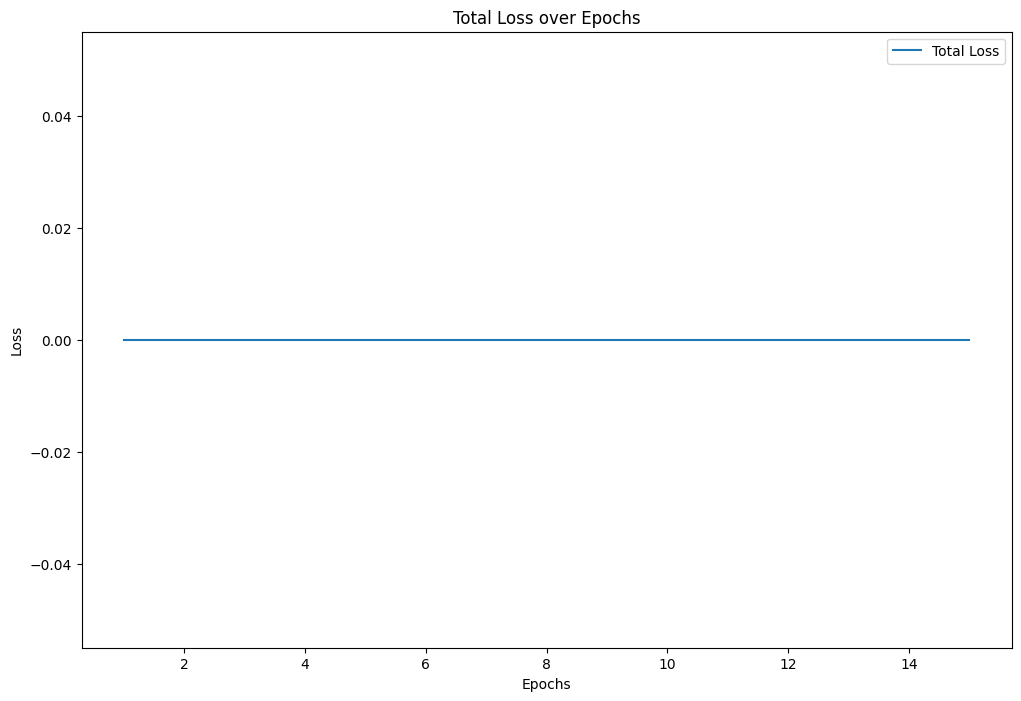

In [19]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA=10.0):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA=5.0):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss


    monet_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
    photo_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

    # Предположим, что у вас есть определенные функции генераторов и дискриминаторов
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer=monet_generator_optimizer,
        p_gen_optimizer=photo_generator_optimizer,
        m_disc_optimizer=monet_discriminator_optimizer,
        p_disc_optimizer=photo_discriminator_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=15,
    callbacks=[loss_history]  # Убедитесь, что у вас определен callback для потерь
)


In [70]:
# cycle_gan_model.fit(
#     tf.data.Dataset.zip((monet_ds, photo_ds)),
#     epochs = 15, callbacks=[loss_history]
# )

Epoch 1/15
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - monet_disc_loss: 0.4429 - monet_gen_loss: 9.4756 - photo_disc_loss: 0.3152 - photo_gen_loss: 9.8413

InvalidArgumentError: Graph execution error:

Detected at node add_5 defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [3,16,16] vs. [10,16,16]
	 [[{{node add_5}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_42789[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_43366]

In [21]:
@tf.function(input_signature=[tf.TensorSpec(shape=[None, 256, 256, 3], dtype=tf.float32)])
def serving_function(input_tensor):
    return {"output": cycle_gan_model(input_tensor)}

model_save_path = 'cycle_gan_model_with_signature'

try:
    tf.saved_model.save(cycle_gan_model, model_save_path, signatures={'serving_default': serving_function})
    print(f"Модель сохранена в {model_save_path} с сигнатурой 'serving_default'")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")


Модель сохранена в cycle_gan_model_with_signature с сигнатурой 'serving_default'


In [31]:
# model_save_path = 'saved_model/cycle_gan_model'
# tf.saved_model.save(cycle_gan_model, model_save_path)


In [22]:
import shutil

shutil.make_archive('cycle_gan_model', 'zip', '/kaggle/working/cycle_gan_model_with_signature')


'/kaggle/working/cycle_gan_model.zip'

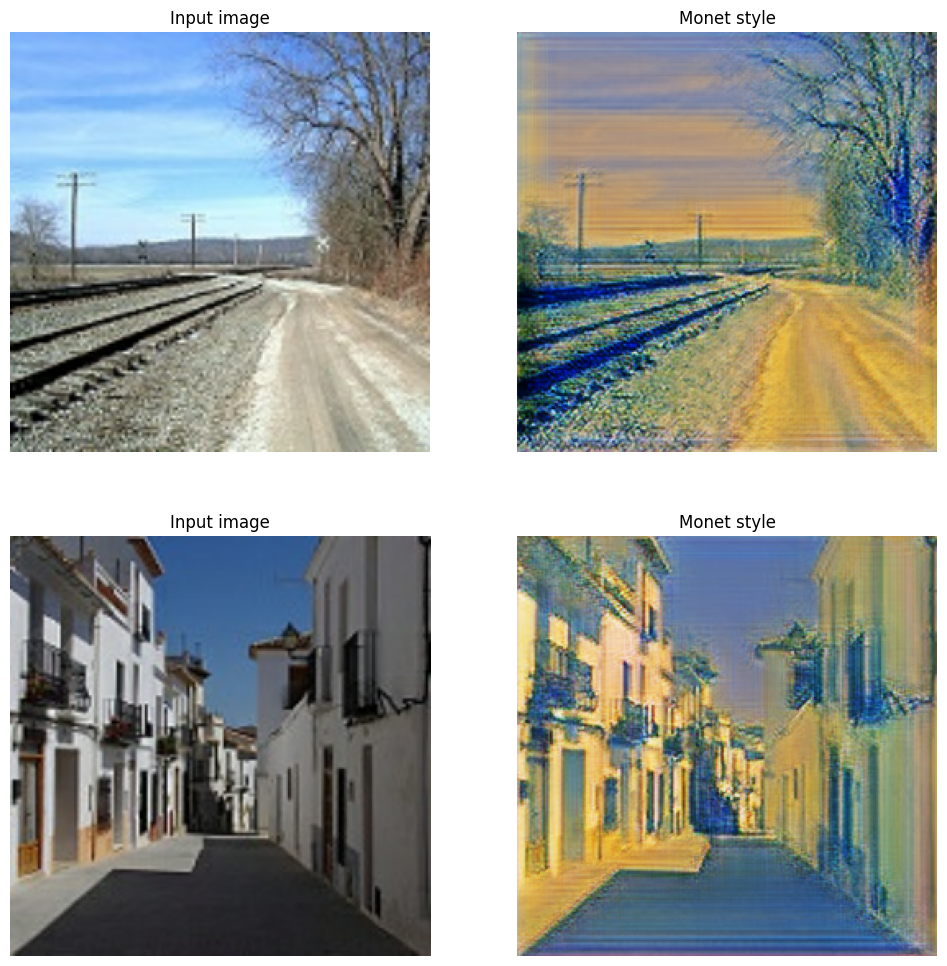

In [20]:
_, ax = plt.subplots(2, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(2)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Monet style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [75]:
import tensorflow as tf
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Функции для расчета метрик
def calculate_mse(real_images, generated_images):
    mse = tf.reduce_mean(tf.square(real_images - generated_images))
    return mse.numpy()

def calculate_psnr(real_images, generated_images):
    psnr = tf.image.psnr(real_images, generated_images, max_val=1.0)
    return tf.reduce_mean(psnr).numpy()

def calculate_ssim(real_images, generated_images):
    ssim_value = tf.image.ssim(real_images, generated_images, max_val=1.0)
    return tf.reduce_mean(ssim_value).numpy()

# Пример генерации данных для демонстрации
real_images = np.random.rand(10, 256, 256, 3)
generated_images = real_images + np.random.normal(0, 0.1, real_images.shape)

# Преобразование данных в тензоры
real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)

# Расчет метрик
mse_value = calculate_mse(real_images, generated_images)
psnr_value = calculate_psnr(real_images, generated_images)
ssim_value = calculate_ssim(real_images, generated_images)

print(f'MSE: {mse_value}')
print(f'PSNR: {psnr_value}')
print(f'SSIM: {ssim_value}')


MSE: 0.010002360679209232
PSNR: 19.998987197875977
SSIM: 0.9414466023445129


In [23]:
import tensorflow as tf
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Функции для расчета метрик
def calculate_mse(real_images, generated_images):
    mse = tf.reduce_mean(tf.square(real_images - generated_images))
    return mse.numpy()

def calculate_psnr(real_images, generated_images):
    psnr = tf.image.psnr(real_images, generated_images, max_val=1.0)
    return tf.reduce_mean(psnr).numpy()

def calculate_ssim(real_images, generated_images):
    ssim_value = tf.image.ssim(real_images, generated_images, max_val=1.0)
    return tf.reduce_mean(ssim_value).numpy()

# Пример генерации данных для демонстрации
real_images = np.random.rand(10, 256, 256, 3)
generated_images = real_images + np.random.normal(0, 0.1, real_images.shape)

# Преобразование данных в тензоры
real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)

# Расчет метрик
mse_value = calculate_mse(real_images, generated_images)
psnr_value = calculate_psnr(real_images, generated_images)
ssim_value = calculate_ssim(real_images, generated_images)

print(f'MSE: {mse_value}')
print(f'PSNR: {psnr_value}')
print(f'SSIM: {ssim_value}')


MSE: 0.009988094680011272
PSNR: 20.005191802978516
SSIM: 0.9414661526679993
